In [19]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from matplotlib.colors import Normalize
import cv2
import tqdm

In [3]:
fly = '339'

In [4]:
dataset_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'
load_directory = os.path.join(dataset_path,F'fly_{fly}/func_0')
file = os.path.join(load_directory, 'functional_channel_2_moco_zscore_highpass.h5')

with h5py.File(file, 'r') as hf:
    print(hf['data'].shape)
    data = hf['data'][:]

(130, 31, 11, 17588)


In [5]:
dims = {'x':data.shape[0],
        'y':data.shape[1],
        'z':data.shape[2],
        't':data.shape[3]}

In [6]:
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))

fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))
resolution = 10 #desired resolution in ms
fps = 100
expt_len = fictrac_raw.shape[0]/fps*1000
fictrac_raw.shape

Trying to load timestamp data from hdf5 file.
Success.


(182788, 25)

In [7]:
behaviors = ['dRotLabZneg', 'dRotLabZpos', 'dRotLabY']
fictrac = {}
z=5
for behavior,short in zip(behaviors,['R','L','F']):
    fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)
    fictrac[short] = fictrac_interp

In [17]:
### SPLIT DATA BY HEMISPHERE ###
data_hemi = {}
data_hemi['L'] = data[:int(dims['x']/2),...]
data_hemi['R'] = data[int(dims['x']/2):,...]

In [21]:
### MAKE CLUSTER DIRECTORY ###
cluster_dir = os.path.join(load_directory, 'clustering')
if not os.path.exists(cluster_dir):
    os.mkdir(cluster_dir)
    

### FIT CLUSTERS ###
labels = {}
n_clusters = 200
for hemi in ['L','R']:
    connectivity = grid_to_graph(data_hemi[hemi].shape[0],dims['y'],dims['z'])
    neural_activity = data_hemi[hemi].reshape(-1, dims['t'])
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=cluster_dir,
                                linkage='ward',
                                connectivity=connectivity)
    cluster_model.fit(neural_activity)
    cluster_labels = cluster_model.labels_
    labels[hemi] = np.asarray(cluster_labels)
    
#save_file = os.path.join(cluster_dir, 'cluster_labels.npy')
#np.save(save_file,cluster_labels)

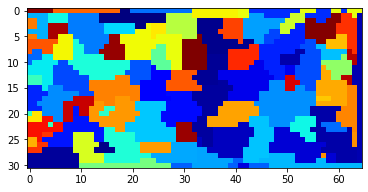

In [26]:
hemi = 'R'

cluster_labels_3d = np.reshape(labels[hemi],(data_hemi[hemi].shape[0],dims['y'],dims['z']))
plt.imshow(cluster_labels_3d[:,:,7].T,cmap='jet')

In [49]:
### GET CLUSTER AVERAGE SIGNAL ###
signals = {}
for hemi in ['L', 'R']:
    signals[hemi] = []
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(labels[hemi]==cluster_num)[0]
        mean_signal = np.mean(data_hemi[hemi].reshape(-1, dims['t'])[cluster_indicies,:], axis=0)
        signals[hemi].append(mean_signal)
    signals[hemi] = np.nan_to_num(np.asarray(signals[hemi])).astype('float64')
    print(signals[hemi].shape)

(200, 17588)
(200, 17588)


In [51]:
sym_filter = {}
for hemi in ['L', 'R']:
    sym_filter[hemi] = []
    for cluster_num in range(n_clusters):
        cc_R = scipy.signal.correlate(signals[hemi][cluster_num,:], fictrac['R'])
        cc_L = scipy.signal.correlate(signals[hemi][cluster_num,:], fictrac['L'])
        sym_filter[hemi].append(cc_R-cc_L)
    sym_filter[hemi] = np.asarray(sym_filter[hemi])

In [52]:
timestep = np.diff(timestamps[:,0])[0] #is units of ms
window_30s = int(1000*30/timestep)

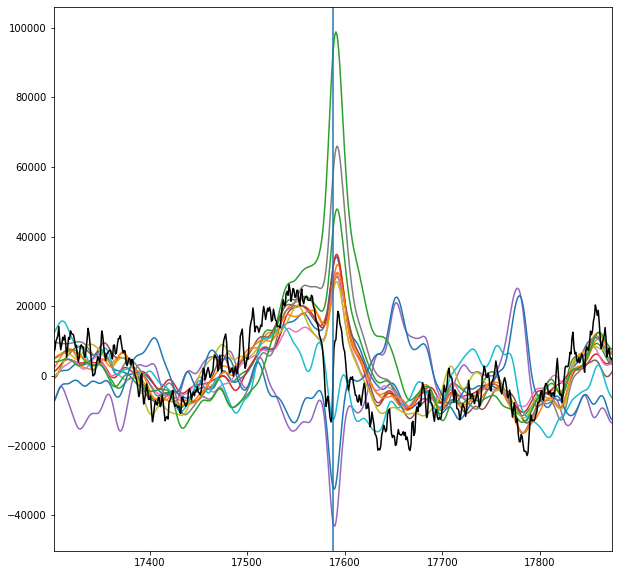

In [165]:
plt.figure(figsize=(10,10))
hemi = 'L'
clusters = []
cnt = 0
for cluster_num in range(n_clusters): 
    if np.abs(sym_filter[hemi][cluster_num,dims['t']]) > 30000:
        if np.abs(np.mean(sym_filter[hemi][cluster_num,dims['t']-100:dims['t']-30])) > 5000:
            smo = gaussian_filter1d(sym_filter[hemi][cluster_num,:],5)
            plt.plot(smo)#+40000*cnt)
            clusters.append(cluster_num)
            #plt.axhline(40000*cnt,color='k')
            cnt+=1

plt.plot(sym_filter[hemi][117,:],color='k')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

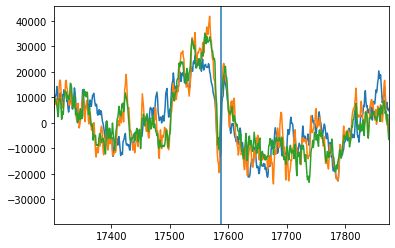

In [161]:
plt.plot(sym_filter[hemi][117,:])
plt.plot(sym_filter[hemi][110,:])
plt.plot(sym_filter[hemi][59,:])


plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

In [138]:
sym_filter[hemi].shape

(200, 35175)

In [141]:
np.mean(sym_filter[hemi][:,dims['t']-100:dims['t']-30],axis=1).shape

(200,)

In [159]:
np.argsort(np.mean(sym_filter[hemi][:,dims['t']-100:dims['t']-30],axis=1))

array([164, 105, 158, 149, 177, 153, 192, 159, 137,   3,  44, 189,  46,
       107, 173, 178, 172, 165, 139, 141, 130,  65,  60, 112, 157, 163,
         0,  53, 125,  84, 103, 169, 166, 182,  18, 104,  14, 188,   5,
       167, 145,  55,  95, 135,  49,  23,  99, 148, 179,  83, 115, 196,
        47,  90,  85,  81,  74,  24,  77, 116, 161,  36,  80, 136, 171,
       101,  56,  21, 191,  16,   4,  98,  26, 142,  42, 140,  68,  91,
        78,  28,  40,  69,  17,   6,  12,  37, 152, 138,  76, 195, 102,
       194,  96, 127, 198, 183,  50,  38,   7,  54,  64,  67, 184,  58,
       129, 156,  97,  30,  10,  62,  45, 100, 150,  88, 151, 121,  48,
       133, 111,  61, 118,  94, 128, 113, 190, 122,  29, 124,  13, 126,
        87,  35,  86,  71,  66,  27, 109, 197, 123,  93,  82,   8, 181,
        57,  25,  51, 155,  70, 144, 120, 134,  41, 187, 162, 132,   2,
        19, 186, 174, 199, 106,  72,  31, 143, 147,  11, 154, 176, 131,
        32,  52, 114,  92,   9, 193,  63,   1, 168, 175,  33, 17

In [ ]:
plt.figure(figsize=(10,10))
hemi = 'L'
clusters = []
cnt = 0

thresh = np.percentile(np.abs(sym_filter[hemi][:,dims['t']]),80)

for cluster_num in range(n_clusters): 
    if np.abs(sym_filter[hemi][cluster_num,dims['t']]) > thresh:
        if np.abs(np.mean(sym_filter[hemi][cluster_num,dims['t']-100:dims['t']-30])) > 5000:
            plt.plot(sym_filter[hemi][cluster_num,:]+40000*cnt)
            clusters.append(cluster_num)
            plt.axhline(40000*cnt,color='k')
            cnt+=1

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

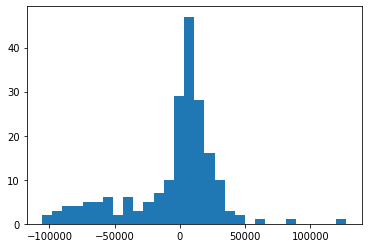

In [127]:
plt.hist(sym_filter['L'][:,dims['t']],bins=30);

In [131]:
thresh = np.percentile(np.abs(sym_filter['L'][:,dims['t']]),80)

40336.3736401095

In [109]:
clusters

[2, 34, 43, 72, 105, 119, 132, 144, 146, 151, 164, 170, 176]

In [145]:
empty = np.zeros(labels[hemi].shape)
for c in [117]:
    empty[np.where(labels[hemi]==c)[0]] = 1
empty = np.reshape(empty,(data_hemi[hemi].shape[0],dims['y'],dims['z']))

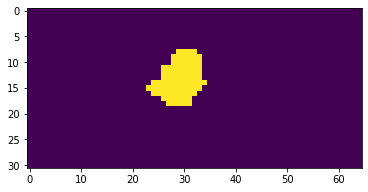

In [146]:
plt.imshow(np.max(empty,axis=-1).T)

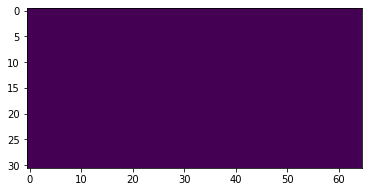

In [156]:
plt.imshow(empty[:,:,10].T)

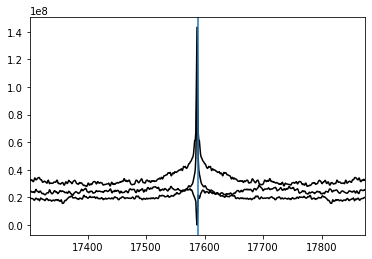

In [98]:
cc = scipy.signal.correlate(fictrac['L'], fictrac['R'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['L'], fictrac['L'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['R'], fictrac['R'])
plt.plot(cc,color='k')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])